In [ ]:
! pip install --upgrade networkx matplotlib
!pip install node2vec
!pip install umap-learn


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np 


# Load the GML file
gml_graph = nx.read_gml('polbooks.gml')

# Now you can work with the graph object
print(len(gml_graph.nodes), len(gml_graph.edges))
#print(gml_graph.nodes(data=True))  # Print nodes with their attributes
print(gml_graph.edges(data=True))  # Print edges with their attributes


105 441
[('1000 Years for Revenge', 'Bush vs. the Beltway', {}), ('1000 Years for Revenge', "Charlie Wilson's War", {}), ('1000 Years for Revenge', 'Losing Bin Laden', {}), ('1000 Years for Revenge', 'Sleeping With the Devil', {}), ('1000 Years for Revenge', 'The Man Who Warned America', {}), ('1000 Years for Revenge', 'Why America Slept', {}), ('Bush vs. the Beltway', 'Losing Bin Laden', {}), ('Bush vs. the Beltway', 'The Man Who Warned America', {}), ('Bush vs. the Beltway', 'Why America Slept', {}), ("Charlie Wilson's War", 'Sleeping With the Devil', {}), ("Charlie Wilson's War", 'The Man Who Warned America', {}), ("Charlie Wilson's War", 'Ghost Wars', {}), ('Losing Bin Laden', 'The Man Who Warned America', {}), ('Losing Bin Laden', 'A National Party No More', {}), ('Losing Bin Laden', 'Bush Country', {}), ('Losing Bin Laden', 'Dereliction of Duty', {}), ('Losing Bin Laden', 'Legacy', {}), ('Losing Bin Laden', 'Off with Their Heads', {}), ('Losing Bin Laden', 'Persecution', {}), ('L

In [28]:
nodes = ['A', 'B', 'C', 'D']
edges = [('A','B'), ('A', 'C'), ("B", "C"), ("C", "D")]
values = { 'A':10,
           'B':20,
        'C': 10
        }

[('A', {'values': 10}), ('B', {'values': 20}), ('C', {'values': 10}), ('D', {})]
   A  B  C  D
A  0  1  1  0
B  1  0  1  0
C  1  1  0  1
D  0  0  1  0


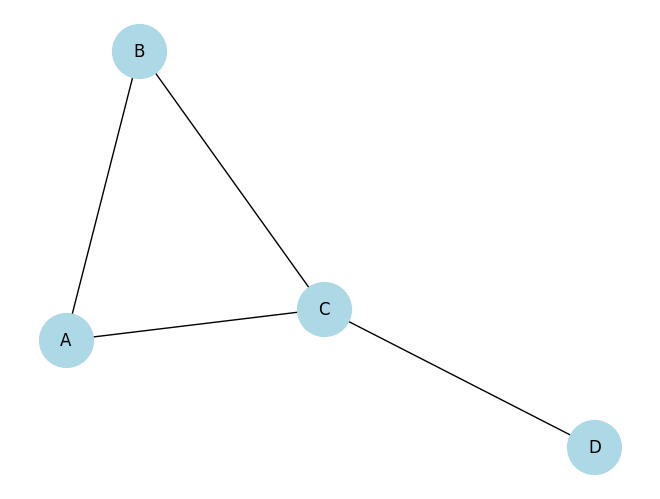

In [29]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.set_node_attributes(G,values, name="values")
print(G.nodes(data=True))

nx.draw(G, with_labels=True, node_color='lightblue', node_size=1500)
plt.savefig('graph.png')

# Generate the adjacency matrix

adj_matrix = nx.to_numpy_array(G, nodelist=nodes)
adj_df = pd.DataFrame(adj_matrix, index=nodes, columns=nodes, dtype=int)
print(adj_df)
nx.write_gml(G, 'adj.gml',)


In [30]:
gml = nx.read_gml('adj.gml')
print(len(gml.nodes),len(gml.edges))
print(gml.nodes(data=True),gml.edges(data=True))

4 4
[('A', {'values': 10}), ('B', {'values': 20}), ('C', {'values': 10}), ('D', {})] [('A', 'B', {}), ('A', 'C', {}), ('B', 'C', {}), ('C', 'D', {})]


In [4]:
# Initialize a dictionary to store counts
value_counts = {}

# Iterate through the list of tuples
for _, attributes in gml_graph.nodes(data=True):
    value = attributes['value']
    if value in value_counts:
        value_counts[value] += 1
    else:
        value_counts[value] = 1

# Print the counts for each 'value'
print(value_counts)



{'n': 13, 'c': 49, 'l': 43}


In [5]:
# Category proportions

[ v/105 for k,v in value_counts.items()]

[0.12380952380952381, 0.4666666666666667, 0.4095238095238095]

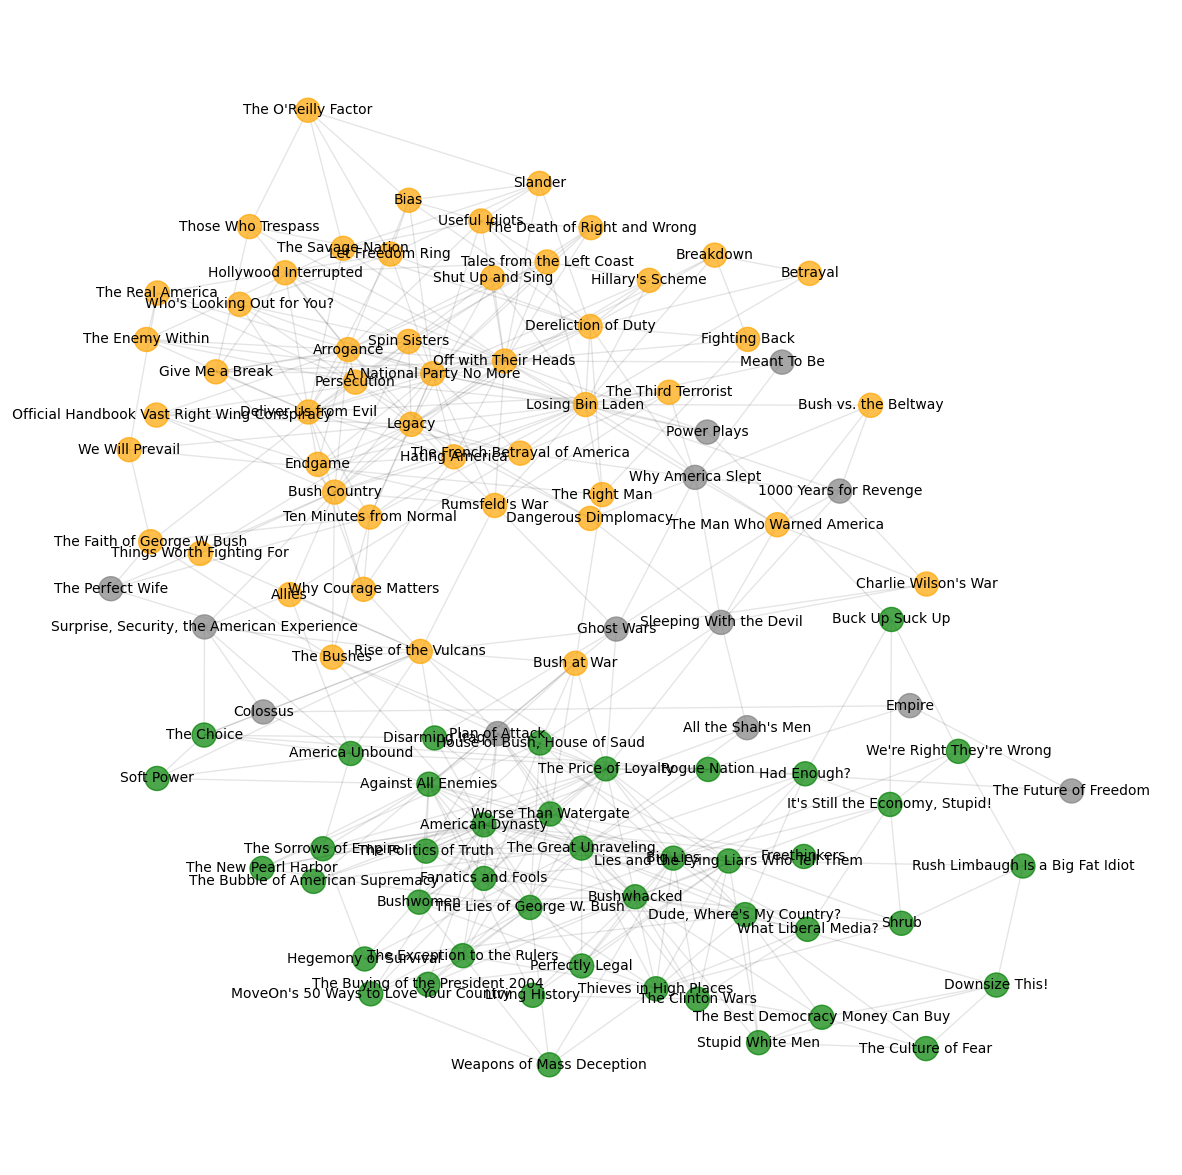

In [6]:
# import matplotlib.pyplot as plt
# import networkx as nx

# Increase figure size
plt.figure(figsize=(15, 15))

# Change layout
pos = nx.kamada_kawai_layout(gml_graph)

# Adjust node size (optional, if you have a measure like degree to scale by)
# node_sizes = [gml_graph.degree[node] * 100 for node in gml_graph.nodes()]

# Adjust font size
font_sizes = 10  # or any other size

# Define your color mapping
color_map = {'l': 'green', 'c': 'orange', 'n': 'grey'}
node_colors = [color_map[gml_graph.nodes[node]['value']] for node in gml_graph.nodes()]

# Draw nodes
nx.draw_networkx_nodes(gml_graph, pos, node_color=node_colors, alpha=0.7)

# Draw edges with transparency
nx.draw_networkx_edges(gml_graph, pos, alpha=0.1)

# Draw labels with font size
nx.draw_networkx_labels(gml_graph, pos, font_size=font_sizes)

# Remove the axes
plt.axis('off')

# Show the plot
plt.show()


/Users/sbrunswi/projects/GNNs-in-action/gnn-venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 213.77it/s]
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


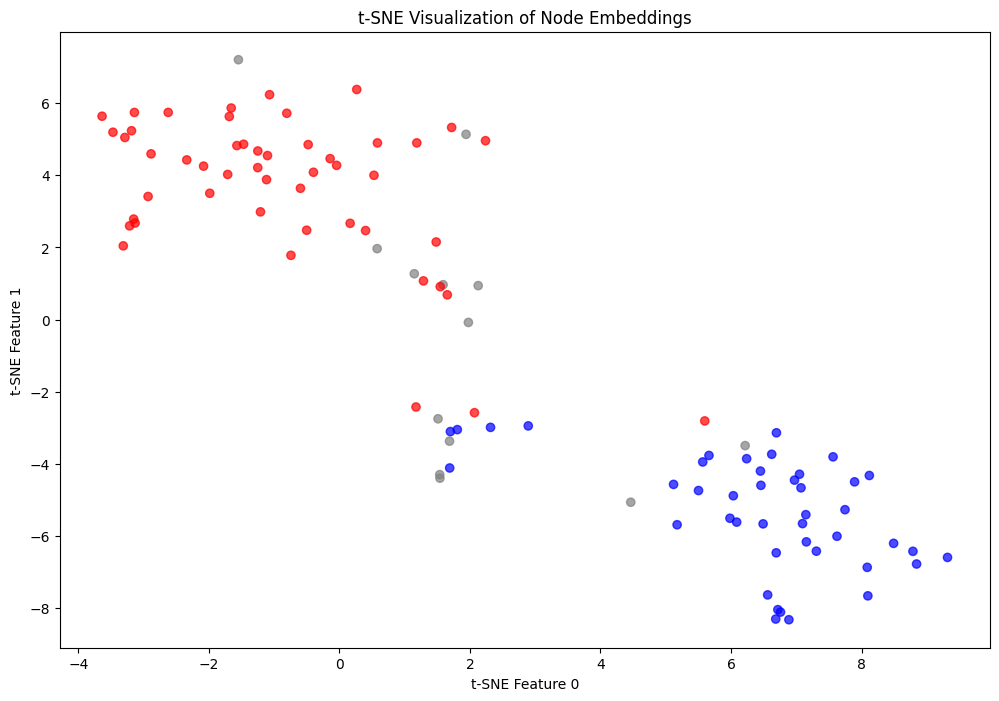

In [32]:
from node2vec import Node2Vec
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'gml_graph' is your loaded graph from the GML file
node2vec = Node2Vec(gml_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Extract node embeddings into a dictionary
embeddings = {str(node): model.wv[str(node)] for node in gml_graph.nodes()}

# Prepare a color map and the colors for each node
color_map = {'l': 'blue', 'c': 'red', 'n': 'grey'}
node_colors = [color_map[gml_graph.nodes[node]['value']] for node in gml_graph.nodes()]

# Transform the embeddings into a list of vectors for t-SNE
node_embeddings = [embeddings[str(node)] for node in gml_graph.nodes()]
node_embeddings_array = np.array(node_embeddings)  # Convert list to NumPy array

# Initialize and fit t-SNE
tsne_model = TSNE(n_components=2, learning_rate='auto', init='random')
tsne_features = tsne_model.fit_transform(node_embeddings_array)

# Plot the nodes with t-SNE embeddings and color by their 'value'
plt.figure(figsize=(12, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], color=node_colors, alpha=0.7)

# Optionally, add labels for each point
#for i, node in enumerate(gml_graph.nodes()):
#    plt.annotate(node, (tsne_features[i, 0], tsne_features[i, 1]))

plt.xlabel('t-SNE Feature 0')
plt.ylabel('t-SNE Feature 1')
plt.title('t-SNE Visualization of Node Embeddings')
plt.show()


In [35]:
node_embedding = model.wv['Losing Bin Laden']
print(len(node_embedding))

64


Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 212.78it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


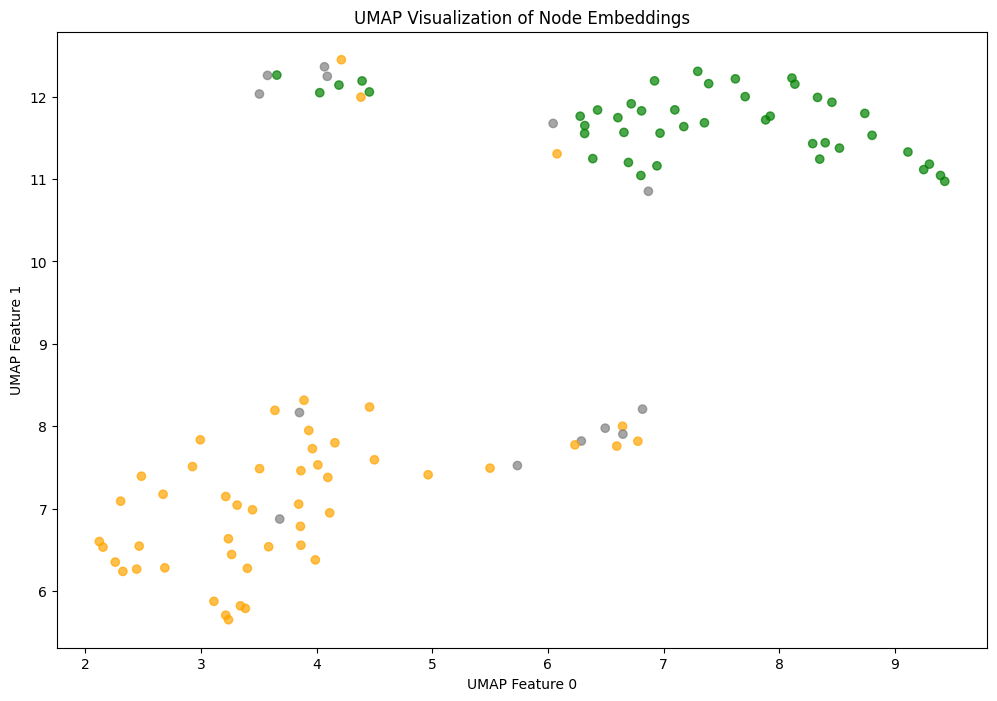

In [7]:
from node2vec import Node2Vec
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import umap


# Assuming 'gml_graph' is your loaded graph from the GML file
node2vec = Node2Vec(gml_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Extract node embeddings into a dictionary
embeddings = {str(node): model.wv[str(node)] for node in gml_graph.nodes()}

# Prepare a color map and the colors for each node
color_map = {'l': 'green', 'c': 'orange', 'n': 'grey'}
node_colors = [color_map[gml_graph.nodes[node]['value']] for node in gml_graph.nodes()]

# Transform the embeddings into a list of vectors for UMAP
node_embeddings = [embeddings[str(node)] for node in gml_graph.nodes()]
node_embeddings_array = np.array(node_embeddings)  # Convert list to NumPy array

# Initialize and fit UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_features = umap_model.fit_transform(node_embeddings_array)

# Plot the nodes with UMAP embeddings and color by their 'value'
plt.figure(figsize=(12, 8))
plt.scatter(umap_features[:, 0], umap_features[:, 1], color=node_colors, alpha=0.7)

# Optionally, add labels for each point
#for i, node in enumerate(gml_graph.nodes()):
#    plt.annotate(node, (umap_features[i, 0], umap_features[i, 1]))

plt.xlabel('UMAP Feature 0')
plt.ylabel('UMAP Feature 1')
plt.title('UMAP Visualization of Node Embeddings')
plt.show()


Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 218.77it/s]
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
/Users/sbrunswi/projects/GNNs-in-action/gnn-venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


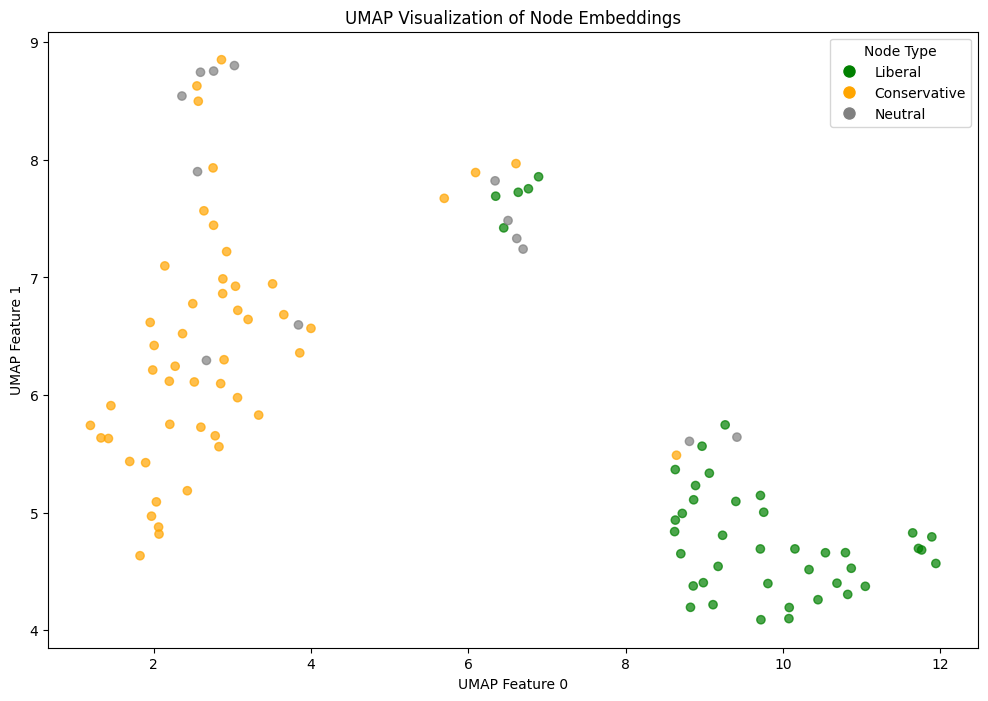

In [8]:
from node2vec import Node2Vec
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import umap

# Assuming 'gml_graph' is your loaded graph from the GML file
node2vec = Node2Vec(gml_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Extract node embeddings into a dictionary
embeddings = {str(node): model.wv[str(node)] for node in gml_graph.nodes()}

# Prepare a color map and the colors for each node
color_map = {'l': 'green', 'c': 'orange', 'n': 'grey'}
node_colors = [color_map[gml_graph.nodes[node]['value']] for node in gml_graph.nodes()]

# Transform the embeddings into a list of vectors for UMAP
node_embeddings = [embeddings[str(node)] for node in gml_graph.nodes()]
node_embeddings_array = np.array(node_embeddings)  # Convert list to NumPy array

# Initialize and fit UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_features = umap_model.fit_transform(node_embeddings_array)

# Plot the nodes with UMAP embeddings and color by their 'value'
plt.figure(figsize=(12, 8))

# Add scatter plot and legend
scatter = plt.scatter(umap_features[:, 0], umap_features[:, 1], color=node_colors, alpha=0.7)
legend_labels = {
    'l': 'Liberal',
    'c': 'Conservative',
    'n': 'Neutral'
}

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[key], 
                      markerfacecolor=color_map[key], markersize=10) for key in legend_labels]

plt.legend(handles=handles, title='Node Type')

# Optionally, add labels for each point
#for i, node in enumerate(gml_graph.nodes()):
#    plt.annotate(node, (umap_features[i, 0], umap_features[i, 1]))

plt.xlabel('UMAP Feature 0')
plt.ylabel('UMAP Feature 1')
plt.title('UMAP Visualization of Node Embeddings')
plt.show()


Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 220.30it/s]
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
/Users/sbrunswi/projects/GNNs-in-action/gnn-venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


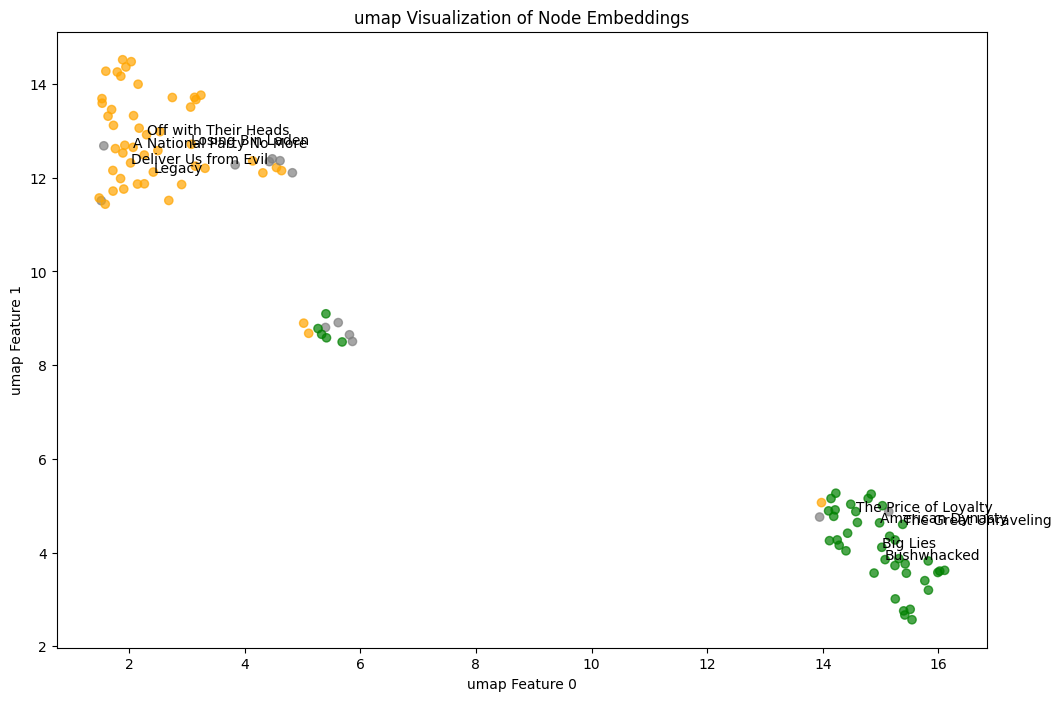

In [9]:
# Assuming 'gml_graph' is your loaded graph from the GML file
node2vec = Node2Vec(gml_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Extract node embeddings into a dictionary
embeddings = {str(node): model.wv[str(node)] for node in gml_graph.nodes()}

# Prepare a color map and the colors for each node
color_map = {'l': 'green', 'c': 'orange', 'n': 'grey'}
node_colors = [color_map[gml_graph.nodes[node]['value']] for node in gml_graph.nodes()]

# Transform the embeddings into a list of vectors for UMAP
node_embeddings = [embeddings[str(node)] for node in gml_graph.nodes()]
node_embeddings_array = np.array(node_embeddings)  # Convert list to NumPy array

# Initialize and fit UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_features = umap_model.fit_transform(node_embeddings_array)

##########################

# Assuming umap_features are the t-SNE 2D embeddings from your previous code
# and gml_graph is your graph object with nodes that have titles as names

# Calculate degrees of nodes and sort them
degrees = dict(gml_graph.degree())
sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)

# Decide how many nodes you want to label
num_labels = 10  # for example, you want to label the top 10 nodes by degree

# Plotting the nodes
plt.figure(figsize=(12, 8))
plt.scatter(umap_features[:, 0], umap_features[:, 1], color=node_colors, alpha=0.7)

# Adding labels to the chosen nodes
for i, node in enumerate(sorted_nodes[:num_labels]):
    # Find the index of the node to get its t-SNE coordinates
    node_index = list(gml_graph.nodes()).index(node)
    plt.annotate(node, (umap_features[node_index, 0], umap_features[node_index, 1]))

plt.xlabel('umap Feature 0')
plt.ylabel('umap Feature 1')
plt.title('umap Visualization of Node Embeddings')
plt.show()


Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 218.66it/s]
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
/Users/sbrunswi/projects/GNNs-in-action/gnn-venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


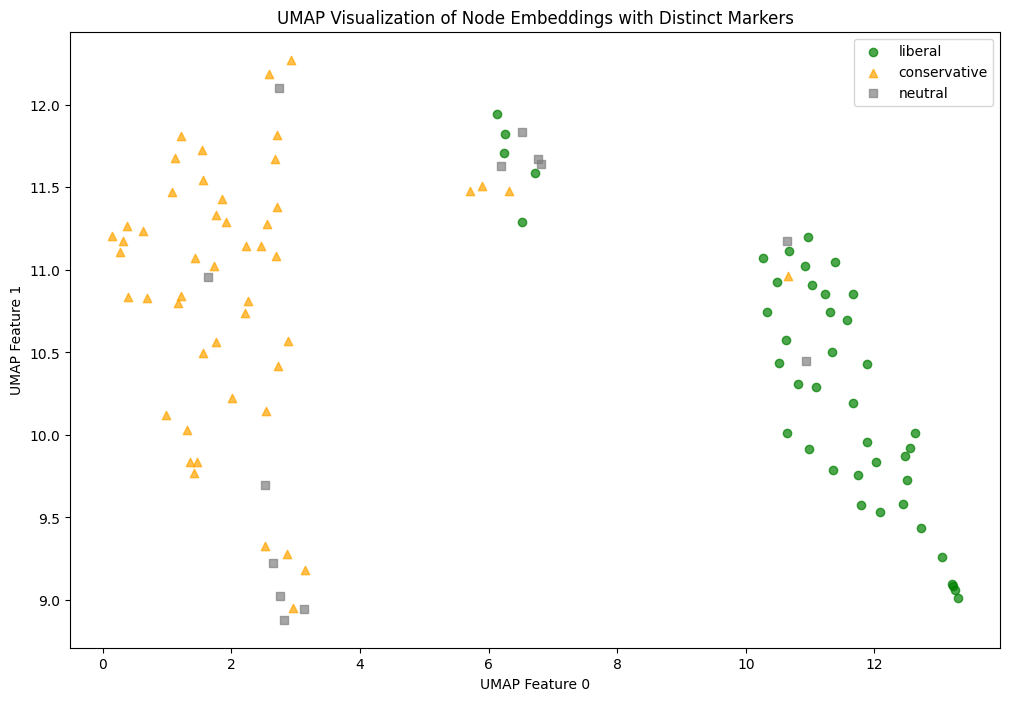

In [10]:
import matplotlib.pyplot as plt
import umap
import numpy as np

# Assuming 'gml_graph' is your loaded graph from the GML file
node2vec = Node2Vec(gml_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Extract node embeddings into a dictionary
embeddings = {str(node): model.wv[str(node)] for node in gml_graph.nodes()}

# Prepare a color map for each node class
color_map = {
    'l': 'green',
    'c': 'orange',
    'n': 'grey'
}

# Prepare a shape map for each node class
shape_map = {
    'l': 'o',  # Circle
    'c': '^',  # Triangle
    'n': 's'   # Square
}

# Map each class letter to a full label
class_labels = {
    'l': 'liberal',
    'c': 'conservative',
    'n': 'neutral'
}

# Create the list of embeddings in the same order as gml_graph.nodes()
node_embeddings = [embeddings[str(node)] for node in gml_graph.nodes()]
node_embeddings_array = np.array(node_embeddings)  # Convert list to NumPy array

# Initialize and fit UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_features = umap_model.fit_transform(node_embeddings_array)

# Calculate degrees of nodes and sort them (for labeling)
degrees = dict(gml_graph.degree())
sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)
num_labels = 10  # Label the top 10 nodes by degree

# --- Plotting Section ---
plt.figure(figsize=(12, 8))

# 1) Plot each class separately with its own color and marker
for class_value in color_map.keys():
    # Identify indices in 'umap_features' belonging to this class
    class_indices = [
        i for i, node in enumerate(gml_graph.nodes()) 
        if gml_graph.nodes[node]['value'] == class_value
    ]

    # Scatter plot for this class
    plt.scatter(
        umap_features[class_indices, 0],
        umap_features[class_indices, 1],
        color=color_map[class_value],
        marker=shape_map[class_value],
        alpha=0.7,
        label=class_labels[class_value]  # Use full label instead of just 'l', 'c', 'n'
    )

# 2) Label the top 'num_labels' nodes by degree
# for node in sorted_nodes[:num_labels]:
#     node_index = list(gml_graph.nodes()).index(node)
#     plt.annotate(
#         node,
#         (umap_features[node_index, 0], umap_features[node_index, 1])
#     )

# Add legend and labels
plt.legend()
plt.xlabel('UMAP Feature 0')
plt.ylabel('UMAP Feature 1')
plt.title('UMAP Visualization of Node Embeddings with Distinct Markers')
plt.show()


Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 210.57it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


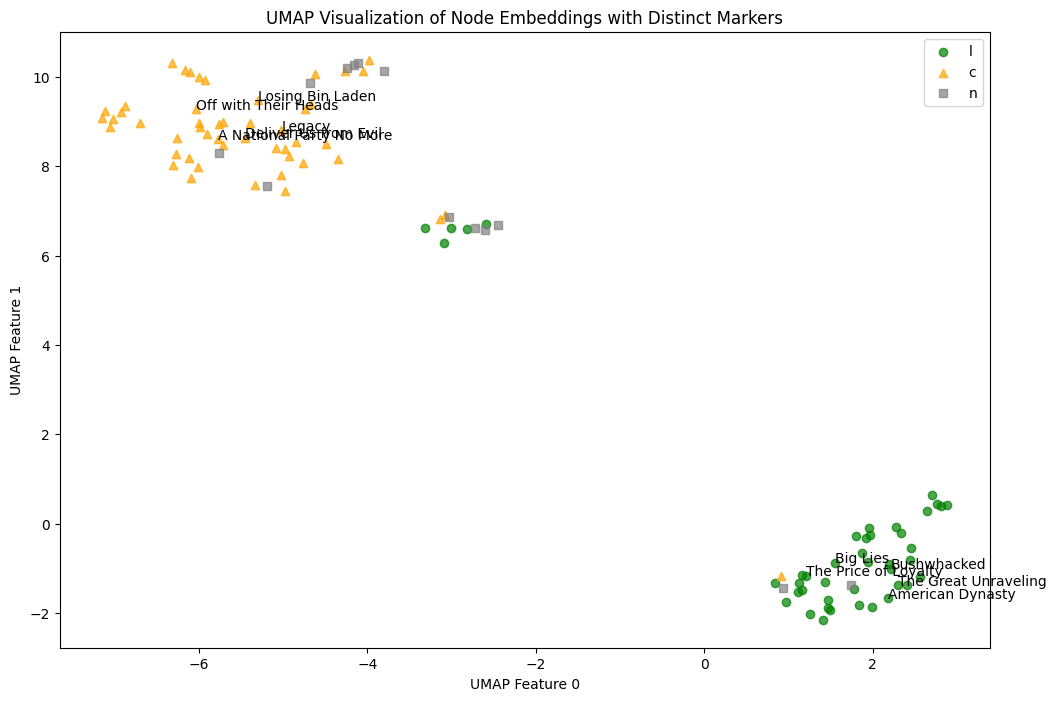

In [17]:
import matplotlib.pyplot as plt
import umap
import numpy as np

# Assuming 'gml_graph' is your loaded graph from the GML file
node2vec = Node2Vec(gml_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Extract node embeddings into a dictionary
embeddings = {str(node): model.wv[str(node)] for node in gml_graph.nodes()}

# Prepare a color map for each node class
color_map = {
    'l': 'green',
    'c': 'orange',
    'n': 'grey'
}

# Prepare a shape map for each node class
shape_map = {
    'l': 'o',  # Circle
    'c': '^',  # Triangle
    'n': 's'   # Square
}

# Create the list of embeddings in the same order as gml_graph.nodes()
node_embeddings = [embeddings[str(node)] for node in gml_graph.nodes()]
node_embeddings_array = np.array(node_embeddings)  # Convert list to NumPy array

# Initialize and fit UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_features = umap_model.fit_transform(node_embeddings_array)

# Calculate degrees of nodes and sort them (for labeling)
degrees = dict(gml_graph.degree())
sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)
num_labels = 10  # Label the top 10 nodes by degree

# --- Plotting Section ---
plt.figure(figsize=(12, 8))

# 1) Plot each class separately with its own color and marker
for class_value in color_map.keys():
    # Identify indices in 'umap_features' belonging to this class
    class_indices = [
        i for i, node in enumerate(gml_graph.nodes()) 
        if gml_graph.nodes[node]['value'] == class_value
    ]

    # Scatter plot for this class
    plt.scatter(
        umap_features[class_indices, 0],
        umap_features[class_indices, 1],
        color=color_map[class_value],
        marker=shape_map[class_value],
        alpha=0.7,
        label=f"{class_value}"
    )

# 2) Label the top 'num_labels' nodes by degree
for node in sorted_nodes[:num_labels]:
    node_index = list(gml_graph.nodes()).index(node)
    plt.annotate(
        node,
        (umap_features[node_index, 0], umap_features[node_index, 1])
    )

# Add legend and labels
plt.legend()
plt.xlabel('UMAP Feature 0')
plt.ylabel('UMAP Feature 1')
plt.title('UMAP Visualization of Node Embeddings with Distinct Markers')
plt.show()


Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 211.74it/s]


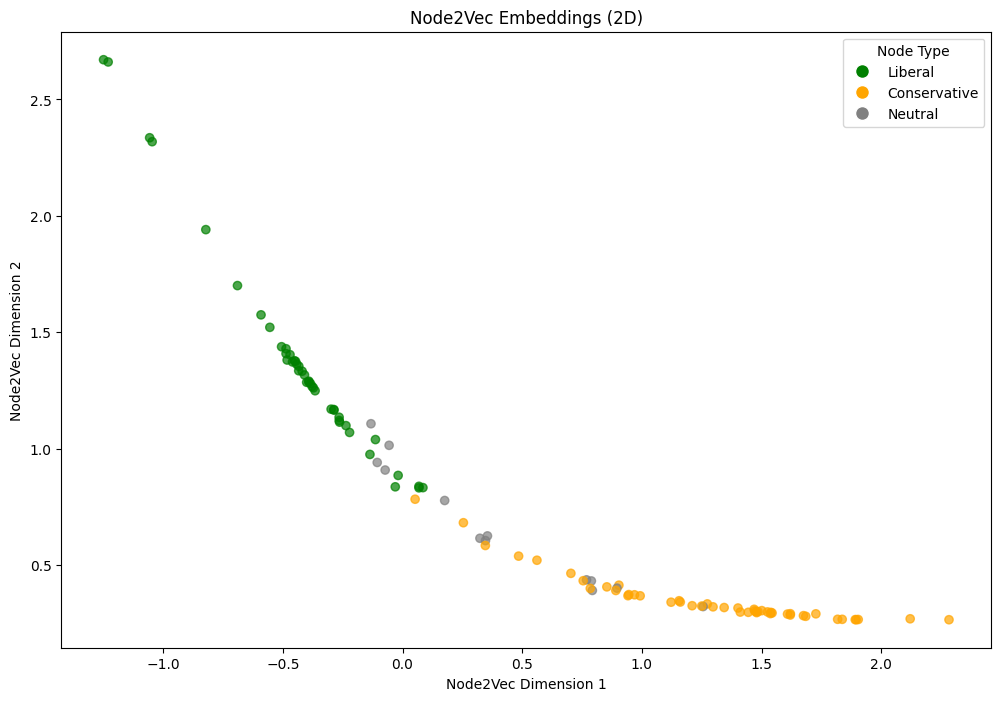

In [22]:
# from node2vec import Node2Vec
# import networkx as nx
# import matplotlib.pyplot as plt

# Assuming 'gml_graph' is your loaded graph from the GML file
# Set dimensions to 2 for direct plotting
node2vec = Node2Vec(gml_graph, dimensions=2, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Extract 2D embeddings into a dictionary
embeddings_2d = {str(node): model.wv[str(node)] for node in gml_graph.nodes()}

# Prepare a color map and the colors for each node based on their 'value'
color_map = {'l': 'green', 'c': 'orange', 'n': 'grey'}
node_colors = [color_map[gml_graph.nodes[node]['value']] for node in gml_graph.nodes()]

# Prepare the 2D points for plotting
points = np.array([embeddings_2d[node] for node in gml_graph.nodes()])

# Plot the nodes with their 2D embeddings
plt.figure(figsize=(12, 8))
plt.scatter(points[:, 0], points[:, 1], color=node_colors, alpha=0.7)

# Optionally, you can label the points
# for i, node in enumerate(gml_graph.nodes()):
#     plt.annotate(node, (points[i, 0], points[i, 1]), fontsize=9)

legend_labels = {
    'l': 'Liberal',
    'c': 'Conservative',
    'n': 'Neutral'
}

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[key], 
                      markerfacecolor=color_map[key], markersize=10) for key in legend_labels]

plt.legend(handles=handles, title='Node Type')



plt.xlabel('Node2Vec Dimension 1')
plt.ylabel('Node2Vec Dimension 2')
plt.title('Node2Vec Embeddings (2D)')
plt.show()


Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 210.53it/s]


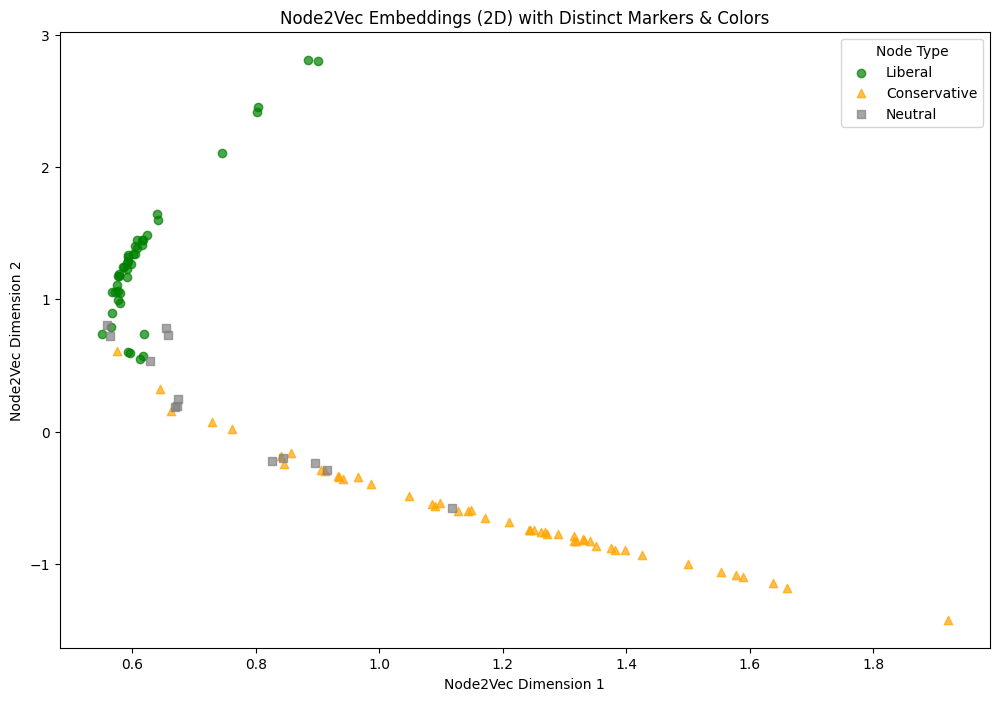

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'gml_graph' is your loaded graph from the GML file

# Set dimensions=2 for direct 2D plotting
node2vec = Node2Vec(gml_graph, dimensions=2, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Extract 2D embeddings into a dictionary
embeddings_2d = {str(node): model.wv[str(node)] for node in gml_graph.nodes()}

# Prepare a color map
color_map = {
    'l': 'green',
    'c': 'orange',
    'n': 'grey'
}

# Prepare a shape map
shape_map = {
    'l': 'o',  # Circle
    'c': '^',  # Triangle
    'n': 's'   # Square
}

# Map each class letter to a full legend label
legend_labels = {
    'l': 'Liberal',
    'c': 'Conservative',
    'n': 'Neutral'
}

# Create a list of nodes to maintain a fixed order
node_list = list(gml_graph.nodes())

# Convert the embeddings to a NumPy array (in the same order as node_list)
points = np.array([embeddings_2d[node] for node in node_list])

# --- Plotting Section ---
plt.figure(figsize=(12, 8))

# Plot each class separately with its own color and marker
for class_value in color_map.keys():
    # Indices of nodes belonging to this class
    class_indices = [
        i for i, node in enumerate(node_list)
        if gml_graph.nodes[node]['value'] == class_value
    ]
    
    # Scatter plot for this class
    plt.scatter(
        points[class_indices, 0],  # x-coordinates
        points[class_indices, 1],  # y-coordinates
        color=color_map[class_value],
        marker=shape_map[class_value],
        alpha=0.7,
        label=legend_labels[class_value]
    )

# Optionally label specific nodes
# for i, node in enumerate(node_list):
#     plt.annotate(node, (points[i, 0], points[i, 1]), fontsize=9)

# Create a legend from the scatter calls above
plt.legend(title='Node Type')

# Axes labels and title
plt.xlabel('Node2Vec Dimension 1')
plt.ylabel('Node2Vec Dimension 2')
plt.title('Node2Vec Embeddings (2D) with Distinct Markers & Colors')
plt.show()


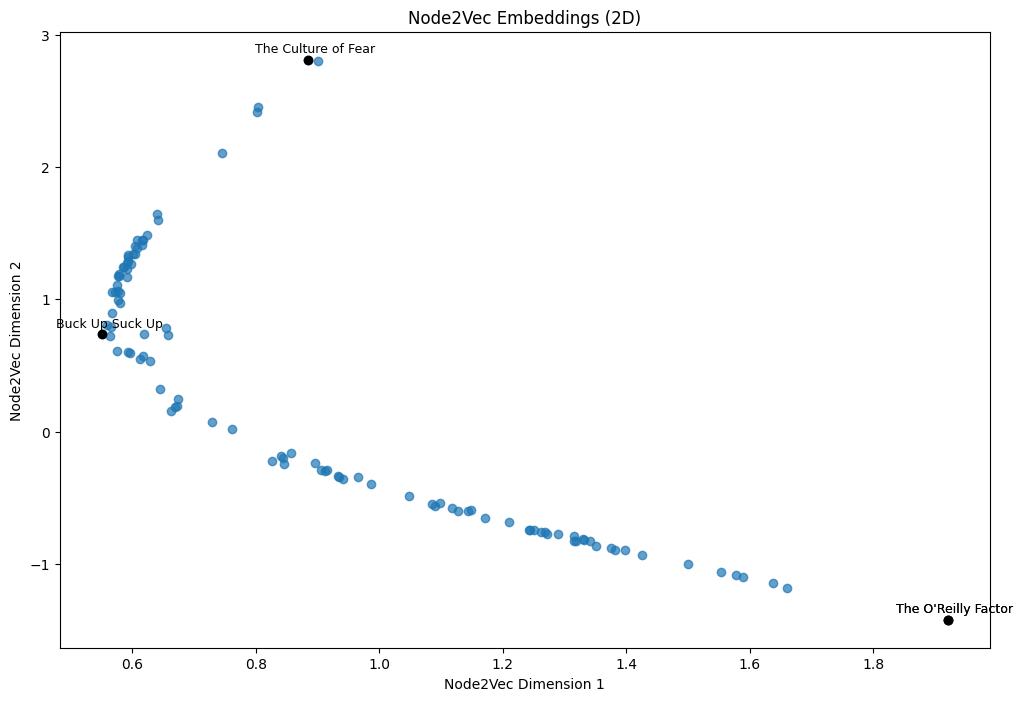

In [25]:
# import numpy as np
# import matplotlib.pyplot as plt

# Let's assume `points` is the numpy array with your Node2Vec 2D points
# and `gml_graph` is your original graph with node labels.

# Identify extreme points
extreme_indices = {
    'leftmost': np.argmin(points[:, 0]),
    'rightmost': np.argmax(points[:, 0]),
    'topmost': np.argmax(points[:, 1]),
    'bottommost': np.argmin(points[:, 1])
}

# Create a figure for plotting
plt.figure(figsize=(12, 8))

# Scatter plot of all points
plt.scatter(points[:, 0], points[:, 1], alpha=0.7)

# Get the node labels from your graph
node_labels = list(gml_graph.nodes())

# Annotate the extreme points
for key, index in extreme_indices.items():
    node_label = node_labels[index]
    x, y = points[index]
    plt.scatter(x, y, color='black')  # Mark the extreme point
    plt.annotate(node_label, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=9)

plt.xlabel('Node2Vec Dimension 1')
plt.ylabel('Node2Vec Dimension 2')
plt.title('Node2Vec Embeddings (2D)')
plt.show()


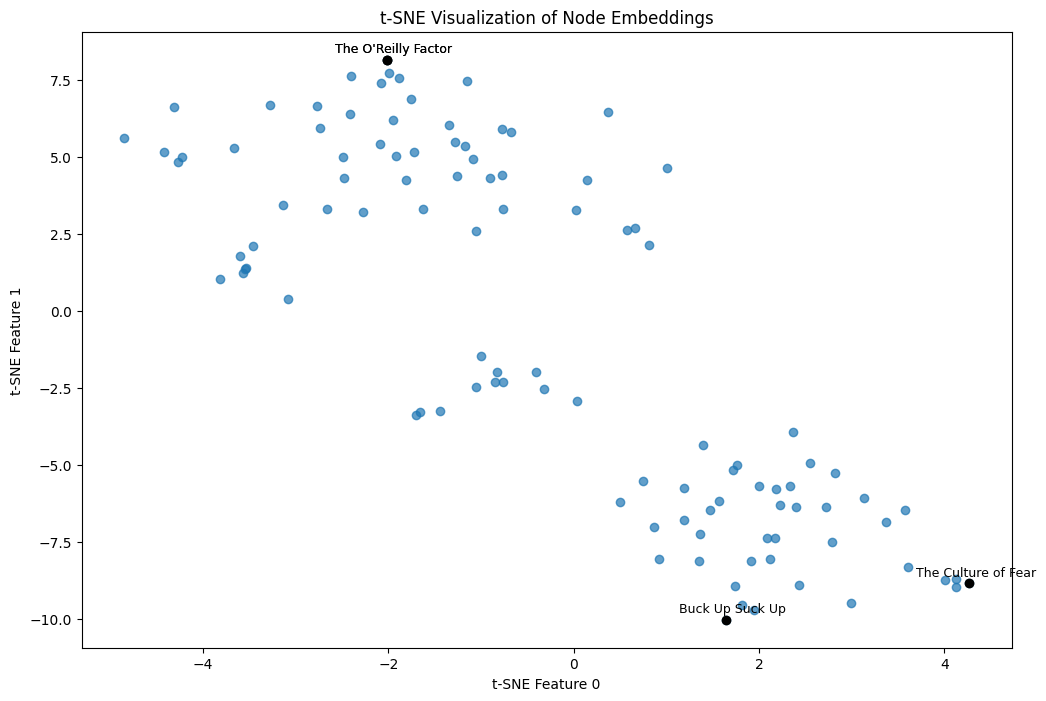

In [26]:
# import numpy as np
# import matplotlib.pyplot as plt

# Assuming `points` contains your Node2Vec 2D points
# and `tsne_features` contains your t-SNE 2D points
# and they are aligned with the nodes in `gml_graph`

# Identify extreme points in Node2Vec space
extreme_indices = {
    'leftmost': np.argmin(points[:, 0]),
    'rightmost': np.argmax(points[:, 0]),
    'topmost': np.argmax(points[:, 1]),
    'bottommost': np.argmin(points[:, 1])
}

# Assuming `tsne_features` is already computed and ready to be plotted
plt.figure(figsize=(12, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], alpha=0.7)

# Get the node labels from your graph
node_labels = list(gml_graph.nodes())

# Annotate the extreme points on the t-SNE plot
for position, index in extreme_indices.items():
    label = node_labels[index]  # Label of the extreme point
    x, y = tsne_features[index]  # Coordinates of the extreme point in t-SNE space
    plt.scatter(x, y, color='black')  # Highlight the extreme point
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=9)

plt.xlabel('t-SNE Feature 0')
plt.ylabel('t-SNE Feature 1')
plt.title('t-SNE Visualization of Node Embeddings')
plt.show()


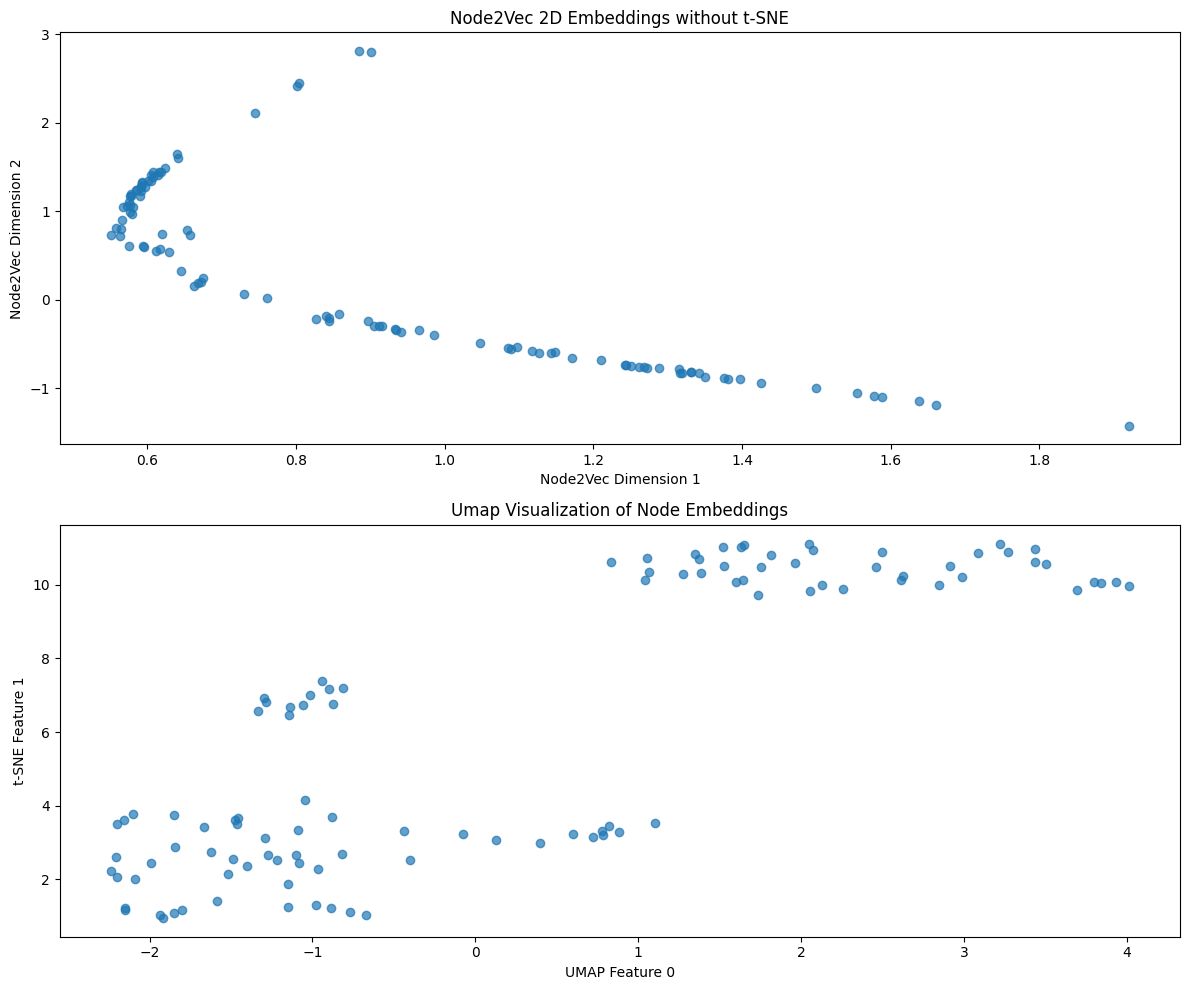

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `points` contains your Node2Vec 2D points
# `tsne_features` contains your t-SNE 2D points
# and they are aligned with the nodes in `gml_graph`

# Identify extreme points in Node2Vec space
extreme_indices = {
    'leftmost': np.argmin(points[:, 0]),
    'rightmost': np.argmax(points[:, 0]),
    'topmost': np.argmax(points[:, 1]),
    'bottommost': np.argmin(points[:, 1])
}

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))  # 2 rows, 1 column

# Plot t-SNE Embeddings in the second subplot
axs[1].scatter(umap_features[:, 0], umap_features[:, 1], alpha=0.7)
# for position, index in extreme_indices.items():
#     label = node_labels[index]
#     x, y = umap_features[index]
#     axs[1].scatter(x, y, color='black')
#     axs[1].annotate(label, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=9)
axs[1].set_title('Umap Visualization of Node Embeddings')
axs[1].set_xlabel('UMAP Feature 0')
axs[1].set_ylabel('t-SNE Feature 1')

# Plot Node2Vec Embeddings in the first subplot
axs[0].scatter(points[:, 0], points[:, 1], alpha=0.7)
# for position, index in extreme_indices.items():
#     label = node_labels[index]
#     x, y = points[index]
#     axs[0].scatter(x, y, color='black')
#     axs[0].annotate(label, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=9)
axs[0].set_title('Node2Vec 2D Embeddings without t-SNE')
axs[0].set_xlabel('Node2Vec Dimension 1')
axs[0].set_ylabel('Node2Vec Dimension 2')



# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [29]:
node_embedding = model.wv['Losing Bin Laden']  
print(node_embedding)  

[ 1.143108  -0.6007532]


In [30]:
type(node_embedding)

numpy.ndarray

In [31]:
# !pip install torch torchvision
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric


  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_sparse-0.6.18-cp311-cp311-macosx_11_0_universal2.whl
  Using cached torch_cluster-1.6.3.tar.gz (54 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_spline_conv-1.2.2.tar.gz (25 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-macosx_11_0_universal2.whl size=323989 sha256=44c7461d11bd5bc8972d8b6e84ce2d5fe8a7b7c2cf57a7be0a3cf750a4093714
  Stored in directory: /Users/keitabroadwater/Library/Caches/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
  Created wheel for torch-cluster: filename=torch_cluster-1.6.3-cp311-cp311-macosx_11_0_universal2.whl size=300298 sha256=f253564105f0299b544a91af1bdd235c6d8ad9d856b79dffb3827dfc53cd6b4a
  Stored in directory: /Users/keitabroadwater/Library/Caches/pip/wheels/ef/de/7d/a4211822af99147b93800e9e204f0be21294e3c0b95b3b861a
  Created 

In [32]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
# import torch_geometric
# print(torch_geometric.__version__)


In [33]:


class SimpleGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        # First Graph Convolutional layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        # Second Graph Convolutional layer
        x = self.conv2(x, edge_index)
        
        # return x
        return x, F.log_softmax(x, dim=1)


In [34]:
from torch_geometric.utils.convert import from_networkx
import torch.nn as nn

# Convert NetworkX graph to a PyTorch Geometric Data object
data = from_networkx(gml_graph)



# Initialize node features with Xavier initialization
num_features = 64  # Set the desired number of features
data.x = torch.empty((data.num_nodes, num_features), dtype=torch.float)  # Create an empty tensor
nn.init.xavier_uniform_(data.x)  # Apply Xavier initialization

# Instantiate the model
model = SimpleGNN(num_features=data.x.shape[1], hidden_channels=64)

# Switch the model to evaluation mode
model.eval()

# Perform a forward pass with no gradient computation
with torch.no_grad():
    gnn_embeddings = model(data.x, data.edge_index)


In [35]:

gnn_embeddings

(tensor([[ 0.0311,  0.0239, -0.0123,  ...,  0.0032,  0.0058, -0.0305],
         [ 0.0248,  0.0175, -0.0088,  ...,  0.0072,  0.0037, -0.0256],
         [ 0.0289,  0.0239, -0.0143,  ..., -0.0047,  0.0061, -0.0266],
         ...,
         [ 0.0350, -0.0247,  0.0094,  ...,  0.0188,  0.0016,  0.0062],
         [ 0.0434, -0.0148, -0.0108,  ..., -0.0215, -0.0092, -0.0315],
         [ 0.0485, -0.0252,  0.0013,  ..., -0.0249, -0.0007, -0.0270]]),
 tensor([[-4.1240, -4.1312, -4.1674,  ..., -4.1519, -4.1493, -4.1856],
         [-4.1318, -4.1391, -4.1655,  ..., -4.1494, -4.1530, -4.1822],
         [-4.1260, -4.1310, -4.1691,  ..., -4.1595, -4.1487, -4.1814],
         ...,
         [-4.1217, -4.1815, -4.1473,  ..., -4.1380, -4.1551, -4.1505],
         [-4.1089, -4.1671, -4.1631,  ..., -4.1738, -4.1615, -4.1838],
         [-4.1052, -4.1789, -4.1524,  ..., -4.1786, -4.1544, -4.1807]]))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/01/5z6fyc3d5ln6y6k70_45q24m0000gn/T/ipykernel_17776/3911076130.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_features[:, 0], umap_features[:, 1], c=node_colors, cmap='viridis', s=15)


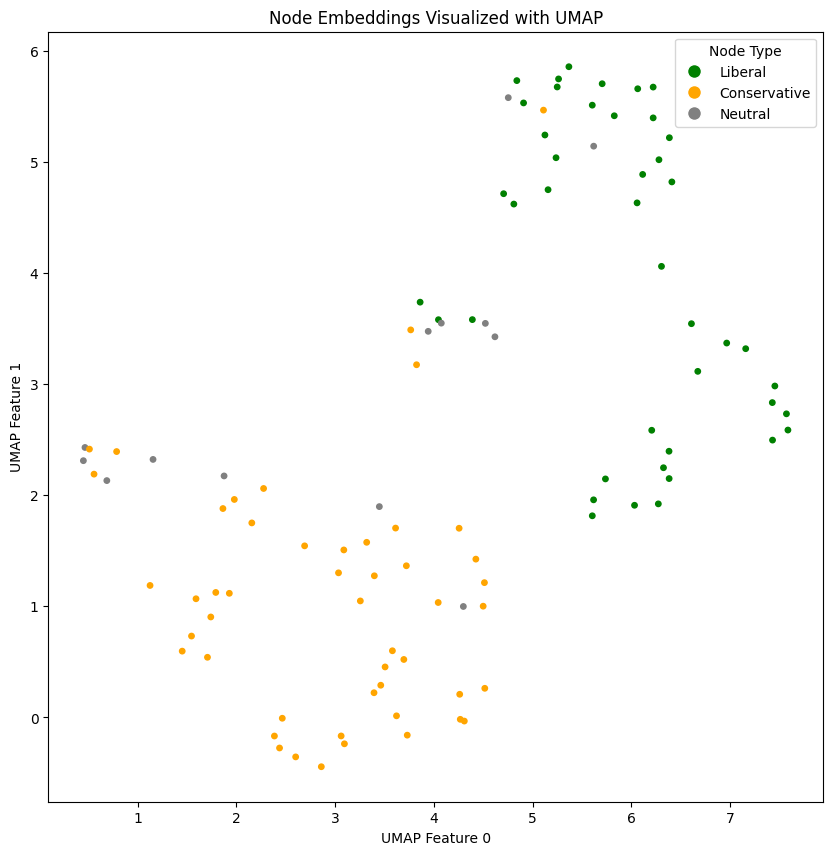

In [47]:
from sklearn.manifold import TSNE

# Convert to numpy for t-SNE
gnn_embeddings_np = gnn_embeddings[0].detach().cpu().numpy() # if using GPU

# Initialize and fit UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_features = umap_model.fit_transform(gnn_embeddings_np)

# Plot the result of t-SNE
plt.figure(figsize=(10, 10))
plt.scatter(umap_features[:, 0], umap_features[:, 1], c=node_colors, cmap='viridis', s=15)
plt.title('Node Embeddings Visualized with UMAP')
plt.xlabel('UMAP Feature 0')
plt.ylabel('UMAP Feature 1')


legend_labels = {
    'l': 'Liberal',
    'c': 'Conservative',
    'n': 'Neutral'
}

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[key], 
                      markerfacecolor=color_map[key], markersize=10) for key in legend_labels]

plt.legend(handles=handles, title='Node Type')

plt.show()


Section 2.3 Using Node Embeddings

In [19]:
import numpy as np
import random

# Extract labels and handle neutral values
labels = []
for node, data in gml_graph.nodes(data=True):
    if data['value'] == 'c':
        labels.append('right')
    elif data['value'] == 'l':
        labels.append('left')
    else:  # Handle neutral and missing values
        labels.append('neutral')

labels = np.array(labels)

# Random seed for reproducibility
random.seed(52)

# Indices of all nodes
indices = list(range(len(labels)))

# Percentage of data to keep as labelled
labelled_percentage = 0.2  # e.g., 10% as labelled

# Select a subset of indices to remain labelled
labelled_indices = random.sample(indices, int(labelled_percentage * len(labels)))

# Initialize masks for labelled and unlabelled data
labelled_mask = np.zeros(len(labels), dtype=bool)
unlabelled_mask = np.ones(len(labels), dtype=bool)

# Update masks
labelled_mask[labelled_indices] = True
unlabelled_mask[labelled_indices] = False

# Use masks to split the dataset
labelled_labels = labels[labelled_mask]
unlabelled_labels = labels[unlabelled_mask]  # You won't use these labels during training

label_mapping = {'left': 0, 'right': 1, 'neutral': 2}
numeric_labels = np.array([label_mapping[label] for label in labels])



In [20]:
labelled_labels


array(['neutral', 'right', 'neutral', 'neutral', 'right', 'right',
       'right', 'right', 'left', 'right', 'right', 'right', 'right',
       'right', 'right', 'left', 'left', 'neutral', 'left', 'left',
       'left'], dtype='<U7')

In [21]:
labels

array(['neutral', 'right', 'right', 'right', 'neutral', 'right',
       'neutral', 'neutral', 'right', 'right', 'right', 'right', 'right',
       'right', 'right', 'right', 'right', 'right', 'neutral', 'right',
       'right', 'right', 'right', 'right', 'right', 'right', 'right',
       'right', 'neutral', 'right', 'left', 'left', 'right', 'right',
       'right', 'right', 'right', 'right', 'right', 'right', 'right',
       'right', 'right', 'right', 'right', 'right', 'neutral', 'right',
       'neutral', 'right', 'right', 'neutral', 'right', 'right', 'right',
       'right', 'right', 'right', 'right', 'left', 'left', 'left', 'left',
       'left', 'left', 'left', 'left', 'left', 'left', 'neutral', 'left',
       'left', 'left', 'left', 'left', 'left', 'neutral', 'right', 'left',
       'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left',
       'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left',
       'left', 'left', 'left', 'left', 'left', 'left', 'left', 'lef

In [22]:
label_mapping = {'left': 0, 'right': 1, 'neutral': 2}
numeric_labels = np.array([label_mapping[label] for label in labels])


# For GNN embeddings
X_train_gnn, y_train_gnn = gnn_embeddings[0][labelled_mask], numeric_labels[labelled_mask]

# For N2V embeddings
# Ensure node2vec embeddings are in the same order as labels
X_n2v = np.array([embeddings[str(node)] for node in gml_graph.nodes()])
X_train_n2v, y_train_n2v = X_n2v[labelled_mask], numeric_labels[labelled_mask]

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Classifier for GNN embeddings
clf_gnn = RandomForestClassifier()
clf_gnn.fit(X_train_gnn, y_train_gnn)

# Classifier for N2V embeddings
clf_n2v = RandomForestClassifier()
clf_n2v.fit(X_train_n2v, y_train_n2v)

from sklearn.metrics import f1_score

# Predictions with GNN embeddings
y_pred_gnn = clf_gnn.predict(gnn_embeddings[0][unlabelled_mask])
# Evaluate GNN classifier
gnn_accuracy = accuracy_score(numeric_labels[unlabelled_mask], y_pred_gnn)
gnn_f1_score = f1_score(numeric_labels[unlabelled_mask], y_pred_gnn, average='weighted')

# Predictions with N2V embeddings
y_pred_n2v = clf_n2v.predict(X_n2v[unlabelled_mask])
# Evaluate N2V classifier
n2v_accuracy = accuracy_score(numeric_labels[unlabelled_mask], y_pred_n2v)
n2v_f1_score = f1_score(numeric_labels[unlabelled_mask], y_pred_n2v, average='weighted')

print(f"GNN Accuracy: {gnn_accuracy:.4f}")
print(f"GNN F1 Score: {gnn_f1_score:.4f}")
print(f"N2V Accuracy: {n2v_accuracy:.4f}")
print(f"N2V F1 Score: {n2v_f1_score:.4f}")


GNN Accuracy: 0.8571
GNN F1 Score: 0.8455
N2V Accuracy: 0.8571
N2V F1 Score: 0.8137


In [ ]:
from sklearn.metrics import log_loss

def adjust_proba(y_pred_proba, all_classes):
    # Check if predicted probabilities cover all classes
    if y_pred_proba.shape[1] != len(all_classes):
        # Create a new array with a column for each class
        adjusted_proba = np.zeros((y_pred_proba.shape[0], len(all_classes)))
        # Fill in the probabilities for the classes that the classifier provided
        for idx, cls in enumerate(clf_gnn.classes_):  # Assuming clf_gnn.classes_ is in the order of the output probabilities
            class_idx = np.where(all_classes == cls)[0][0]
            adjusted_proba[:, class_idx] = y_pred_proba[:, idx]
        return adjusted_proba
    else:
        return y_pred_proba

# Adjust the predicted probabilities
y_pred_proba_gnn_adjusted = adjust_proba(y_pred_proba_gnn, all_classes)
y_pred_proba_n2v_adjusted = adjust_proba(y_pred_proba_n2v, all_classes)


from sklearn.metrics import log_loss

# Compute log loss using the adjusted probabilities
log_loss_gnn = log_loss(numeric_labels[unlabelled_mask], y_pred_proba_gnn_adjusted, labels=all_classes)
log_loss_n2v = log_loss(numeric_labels[unlabelled_mask], y_pred_proba_n2v_adjusted, labels=all_classes)

print(f"GNN Log Loss: {log_loss_gnn:.4f}")
print(f"N2V Log Loss: {log_loss_n2v:.4f}")



In [ ]:
numeric_labels[unlabelled_mask]

In [ ]:
y_pred_proba_gnn

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Classifier for GNN embeddings
clf_gnn = RandomForestClassifier()
clf_gnn.fit(X_train_gnn, y_train_gnn)

# Classifier for N2V embeddings
clf_n2v = RandomForestClassifier()
clf_n2v.fit(X_train_n2v, y_train_n2v)

# Predictions with GNN embeddings
y_pred_gnn = clf_gnn.predict(gnn_embeddings[unlabelled_mask])
# Evaluate GNN classifier
gnn_accuracy = accuracy_score(numeric_labels[unlabelled_mask], y_pred_gnn)

# Predictions with N2V embeddings
y_pred_n2v = clf_n2v.predict(X_n2v[unlabelled_mask])
# Evaluate N2V classifier
n2v_accuracy = accuracy_score(numeric_labels[unlabelled_mask], y_pred_n2v)

print(f"GNN Accuracy: {gnn_accuracy:.4f}")
print(f"N2V Accuracy: {n2v_accuracy:.4f}")


In [ ]:
# Predictions with GNN embeddings
y_pred_gnn = clf_gnn.predict(gnn_embeddings[unlabelled_mask])
# Evaluate GNN classifier
gnn_accuracy = accuracy_score(numeric_labels[unlabelled_mask], y_pred_gnn)

# Predictions with N2V embeddings
y_pred_n2v = clf_n2v.predict(X_n2v[unlabelled_mask])
# Evaluate N2V classifier
n2v_accuracy = accuracy_score(numeric_labels[unlabelled_mask], y_pred_n2v)

print(f"GNN Accuracy: {gnn_accuracy:.4f}")
print(f"N2V Accuracy: {n2v_accuracy:.4f}")


In [ ]:
X_train_n2v

In [ ]:
# Convert NetworkX graph to a PyTorch Geometric Data object
data = from_networkx(gml_graph)

# Prepare the node features (using Node2Vec embeddings)
# node_features = torch.tensor(node_embeddings, dtype=torch.float)

# Add node features to data
# data.x = node_features

# Note: If you have no initial node features, you could alternatively initialize them randomly
data.x = torch.randn((data.num_nodes, 64), dtype=torch.float)

train_labels = torch.tensor(numeric_labels, dtype=torch.long)[labelled_mask]

# Assuming 'labelled_mask' is a boolean array indicating which nodes are labelled
data.train_mask = torch.tensor(labelled_mask, dtype=torch.bool)

In [ ]:
# Define the number of input features and output classes
num_features = data.num_features  # Assuming data.x contains the node features
num_classes = 3  # Assuming you have 3 classes in your classification task

# Initialize the model
class SimpleGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        # First Graph Convolutional layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        # Second Graph Convolutional layer
        x = self.conv2(x, edge_index)
        
        return x, F.log_softmax(x, dim=1)

In [ ]:
class SimpleGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)  # Add another GCN layer
        self.conv4 = GCNConv(hidden_channels, hidden_channels)  # Add another GCN layer

    def forward(self, x, edge_index):
        # First Graph Convolutional layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        # Second Graph Convolutional layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        # Third Graph Convolutional layer
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        # Fourth Graph Convolutional layer
        x = self.conv4(x, edge_index)
        
        return x, F.log_softmax(x, dim=1)


In [ ]:
model = SimpleGNN(num_features=data.x.shape[1], hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [ ]:
class SimpleGNN_2(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(SimpleGNN_2, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = SimpleGNN_2(num_features=num_features, num_classes=num_classes)


In [ ]:

# Convert NetworkX graph to a PyTorch Geometric Data object
data = from_networkx(gml_graph)

# Prepare the node features (using Node2Vec embeddings)
# node_features = torch.tensor(node_embeddings, dtype=torch.float)

# Add node features to data
# data.x = node_features

# Note: If you have no initial node features, you could alternatively initialize them randomly
data.x = torch.randn((data.num_nodes, 64), dtype=torch.float)

In [ ]:
train_labels = torch.tensor(numeric_labels, dtype=torch.long)[labelled_mask]


In [ ]:

# Convert NetworkX graph to a PyTorch Geometric Data object
data = from_networkx(gml_graph)

# Prepare the node features (using Node2Vec embeddings)
# node_features = torch.tensor(node_embeddings, dtype=torch.float)

# Add node features to data
# data.x = node_features

# Note: If you have no initial node features, you could alternatively initialize them randomly
data.x = torch.randn((data.num_nodes, 64), dtype=torch.float)

train_labels = torch.tensor(numeric_labels, dtype=torch.long)[labelled_mask]

# Assuming 'labelled_mask' is a boolean array indicating which nodes are labelled
data.train_mask = torch.tensor(labelled_mask, dtype=torch.bool)



for epoch in range(200):  # Number of epochs
    optimizer.zero_grad()
    # Pass both node features and edge_index to the model
    out = model(data.x, data.edge_index)
    # Apply the training mask to select only the outputs for the labelled nodes
    out_masked = out[data.train_mask]
    # Compute the loss using only the labelled nodes
    loss = loss_fn(out_masked, train_labels)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:  # Print loss every 10 epochs
        print(f'Epoch {epoch}, Log Loss: {loss.item()}')


In [ ]:
# Pass only the labeled nodes to the model for training
out = model(data.x, data.edge_index)[labelled_mask]

# Compute the loss using only the labeled nodes
loss = loss_fn(out, train_labels)

print(f'Training Log Loss: {loss.item()}')


In [ ]:
# Pass the entire dataset through the model to obtain predicted probabilities for all nodes
with torch.no_grad():
    out = model(data.x, data.edge_index)
    # Convert the output into probabilities using softmax
    y_pred_proba_gnn = torch.softmax(out, dim=1).numpy()

# Adjust the predicted probabilities
y_pred_proba_gnn_adjusted = adjust_proba(y_pred_proba_gnn, all_classes)

# Compute log loss using the adjusted probabilities
log_loss_gnn = log_loss(numeric_labels[unlabelled_mask], y_pred_proba_gnn_adjusted, labels=all_classes)

print(f"GNN Log Loss: {log_loss_gnn:.4f}")

In [ ]:
from sklearn.metrics import log_loss

# Convert NetworkX graph to a PyTorch Geometric Data object
data = from_networkx(gml_graph)

# Prepare the node features (using Node2Vec embeddings)
# node_features = torch.tensor(node_embeddings, dtype=torch.float)

# Add node features to data
# data.x = node_features

# Note: If you have no initial node features, you could alternatively initialize them randomly
data.x = torch.randn((data.num_nodes, 64), dtype=torch.float)

train_labels = torch.tensor(numeric_labels, dtype=torch.long)[labelled_mask]

# Assuming 'labelled_mask' is a boolean array indicating which nodes are labelled
data.train_mask = torch.tensor(labelled_mask, dtype=torch.bool)

# Initialize an empty array to store the predicted probabilities
y_pred_proba_gnn = []

for epoch in range(1):  # Number of epochs
    optimizer.zero_grad()
    # Pass both node features and edge_index to the model
    out = model(data.x, data.edge_index)
    # Apply the training mask to select only the outputs for the labelled nodes
    out_masked = out[data.train_mask]
    # Compute the loss using only the labelled nodes
    loss = loss_fn(out_masked, train_labels)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:  # Print loss every 10 epochs
        print(f'Epoch {epoch}, Log Loss: {loss.item()}')

# Pass the entire dataset through the model to obtain predicted probabilities for all nodes
with torch.no_grad():
    out = model(data.x, data.edge_index)
    # Convert the output into probabilities using softmax
    y_pred_proba_gnn = torch.softmax(out, dim=1).numpy()

# Adjust the predicted probabilities
y_pred_proba_gnn_adjusted = adjust_proba(y_pred_proba_gnn, all_classes)

# Compute log loss using the adjusted probabilities
log_loss_gnn = log_loss(numeric_labels[unlabelled_mask], y_pred_proba_gnn_adjusted, labels=all_classes)

print(f"GNN Log Loss: {log_loss_gnn:.4f}")


In [ ]:
from sklearn.metrics import log_loss

# Convert NetworkX graph to a PyTorch Geometric Data object
data = from_networkx(gml_graph)

# Prepare the node features (using Node2Vec embeddings)
node_features = torch.tensor(node_embeddings, dtype=torch.float)

# Add node features to data
data.x = node_features

# Note: If you have no initial node features, you could alternatively initialize them randomly
# data.x = torch.randn((data.num_nodes, 64), dtype=torch.float)

train_labels = torch.tensor(numeric_labels, dtype=torch.long)[labelled_mask]

# Assuming 'labelled_mask' is a boolean array indicating which nodes are labelled
data.train_mask = torch.tensor(labelled_mask, dtype=torch.bool)

# Initialize an empty array to store the predicted probabilities
y_pred_proba_gnn = []

for epoch in range(2000):  # Number of epochs
    optimizer.zero_grad()
    # Pass both node features and edge_index to the model
    _, out = model(data.x, data.edge_index)
    # Apply the training mask to select only the outputs for the labelled nodes
    out_masked = out[data.train_mask]
    # Compute the loss using only the labelled nodes
    loss = loss_fn(out_masked, train_labels)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:  # Print loss every 10 epochs
        print(f'Epoch {epoch}, Log Loss: {loss.item()}')

# Pass the entire dataset through the model to obtain predicted probabilities for all nodes
with torch.no_grad():
    _,out = model(data.x, data.edge_index)
    # Convert the output into probabilities using softmax
    y_pred_proba_gnn = torch.softmax(out, dim=1).numpy()

# Adjust the predicted probabilities
y_pred_proba_gnn_adjusted = adjust_proba(y_pred_proba_gnn, all_classes)

# Apply the unlabelled mask to select only the predicted probabilities for unlabelled nodes
y_pred_proba_gnn_unlabelled = y_pred_proba_gnn_adjusted[unlabelled_mask]

# Compute log loss using the adjusted probabilities
log_loss_gnn = log_loss(numeric_labels[unlabelled_mask], y_pred_proba_gnn_unlabelled, labels=all_classes)

print(f"GNN Log Loss: {log_loss_gnn:.4f}")

from sklearn.metrics import f1_score

# Convert predicted probabilities to predicted labels
y_pred_gnn = np.argmax(y_pred_proba_gnn_unlabelled, axis=1)

# Compute F1 score
f1_gnn = f1_score(numeric_labels[unlabelled_mask], y_pred_gnn, average='weighted')

print(f"GNN F1 Score: {f1_gnn:.4f}")

from sklearn.metrics import accuracy_score

# Get predicted labels by selecting the class with the highest probability for each node
y_pred_labels_gnn = np.argmax(y_pred_proba_gnn_unlabelled, axis=1)

# Calculate accuracy
accuracy_gnn = accuracy_score(numeric_labels[unlabelled_mask], y_pred_labels_gnn)

print(f"GNN Accuracy: {accuracy_gnn:.4f}")


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
patience=50
best_loss = float('inf')
best_epoch = 0


for epoch in range(2000):  # Number of epochs
    optimizer.zero_grad()
    # Pass both node features and edge_index to the model
    _, out = model(data.x, data.edge_index)
    # Apply the training mask to select only the outputs for the labelled nodes
    out_masked = out[data.train_mask]
    # Compute the loss using only the labelled nodes
    loss = loss_fn(out_masked, train_labels)
    loss.backward()
    optimizer.step()

    # Update learning rate scheduler
    scheduler.step(loss)

    if epoch % 10 == 0:  # Print loss every 10 epochs
        print(f'Epoch {epoch}, Log Loss: {loss.item()}')

    # Check for early stopping based on validation loss (not implemented here)
    if loss < best_loss:
        best_loss = loss
        best_epoch = epoch
    elif epoch - best_epoch > patience:  # Patience is the number of epochs to wait before early stopping
        print("Early stopping triggered.")
        break

        # Convert predicted probabilities to predicted labels
y_pred_gnn = np.argmax(y_pred_proba_gnn_unlabelled, axis=1)

# Compute F1 score
f1_gnn = f1_score(numeric_labels[unlabelled_mask], y_pred_gnn, average='weighted')

print(f"GNN F1 Score: {f1_gnn:.4f}")


# Get predicted labels by selecting the class with the highest probability for each node
y_pred_labels_gnn = np.argmax(y_pred_proba_gnn_unlabelled, axis=1)

# Calculate accuracy
accuracy_gnn = accuracy_score(numeric_labels[unlabelled_mask], y_pred_labels_gnn)

print(f"GNN Accuracy: {accuracy_gnn:.4f}")

In [ ]:
from sklearn.metrics import log_loss

# Convert NetworkX graph to a PyTorch Geometric Data object
data = from_networkx(gml_graph)

# Prepare the node features (using Node2Vec embeddings)
# node_features = torch.tensor(node_embeddings, dtype=torch.float)

# Add node features to data
# data.x = node_features

# Note: If you have no initial node features, you could alternatively initialize them randomly
data.x = torch.randn((data.num_nodes, 64), dtype=torch.float)

train_labels = torch.tensor(numeric_labels, dtype=torch.long)[labelled_mask]

# Assuming 'labelled_mask' is a boolean array indicating which nodes are labelled
data.train_mask = torch.tensor(labelled_mask, dtype=torch.bool)

# Initialize an empty array to store the predicted probabilities
y_pred_proba_gnn = []

for epoch in range(3000):  # Number of epochs
    optimizer.zero_grad()
    # Pass both node features and edge_index to the model
    _, out = model(data.x, data.edge_index)
    # Apply the training mask to select only the outputs for the labelled nodes
    out_masked = out[data.train_mask]
    # Compute the loss using only the labelled nodes
    loss = loss_fn(out_masked, train_labels)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:  # Print loss every 10 epochs
        print(f'Epoch {epoch}, Log Loss: {loss.item()}')

# Pass the entire dataset through the model to obtain predicted probabilities for all nodes
with torch.no_grad():
    _,out = model(data.x, data.edge_index)
    # Convert the output into probabilities using softmax
    y_pred_proba_gnn = torch.softmax(out, dim=1).numpy()

# Adjust the predicted probabilities
y_pred_proba_gnn_adjusted = adjust_proba(y_pred_proba_gnn, all_classes)

# Apply the unlabelled mask to select only the predicted probabilities for unlabelled nodes
y_pred_proba_gnn_unlabelled = y_pred_proba_gnn_adjusted[unlabelled_mask]

# Compute log loss using the adjusted probabilities
log_loss_gnn = log_loss(numeric_labels[unlabelled_mask], y_pred_proba_gnn_unlabelled, labels=all_classes)

print(f"GNN Log Loss: {log_loss_gnn:.4f}")

from sklearn.metrics import f1_score

# Convert predicted probabilities to predicted labels
y_pred_gnn = np.argmax(y_pred_proba_gnn_unlabelled, axis=1)

# Compute F1 score
f1_gnn = f1_score(numeric_labels[unlabelled_mask], y_pred_gnn, average='weighted')

print(f"GNN F1 Score: {f1_gnn:.4f}")

from sklearn.metrics import accuracy_score

# Get predicted labels by selecting the class with the highest probability for each node
y_pred_labels_gnn = np.argmax(y_pred_proba_gnn_unlabelled, axis=1)

# Calculate accuracy
accuracy_gnn = accuracy_score(numeric_labels[unlabelled_mask], y_pred_labels_gnn)

print(f"GNN Accuracy: {accuracy_gnn:.4f}")


In [ ]:
from sklearn.metrics import f1_score

# Convert predicted probabilities to predicted labels
y_pred_gnn = np.argmax(y_pred_proba_gnn_unlabelled, axis=1)

# Compute F1 score
f1_gnn = f1_score(numeric_labels[unlabelled_mask], y_pred_gnn, average='weighted')

print(f"GNN F1 Score: {f1_gnn:.4f}")

from sklearn.metrics import accuracy_score

# Get predicted labels by selecting the class with the highest probability for each node
y_pred_labels_gnn = np.argmax(y_pred_proba_gnn_unlabelled, axis=1)

# Calculate accuracy
accuracy_gnn = accuracy_score(numeric_labels[unlabelled_mask], y_pred_labels_gnn)

print(f"GNN Accuracy: {accuracy_gnn:.4f}")



In [ ]:
all_classes

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'model' is your trained GNN model
# Assuming 'data' contains your input graph data
# Assuming 'numeric_labels' contains the numeric labels

# Set model to evaluation mode
model.eval()

# Pass the entire dataset through the model to obtain node embeddings
with torch.no_grad():
    out,_ = model(data.x, data.edge_index)

# Extract embeddings from the output of the GNN model
node_embeddings = out.numpy()

# Reduce dimensionality of embeddings using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(node_embeddings)

# Define colors for different labels
label_colors = {0: 'blue', 1: 'red', 2: 'grey'}

# Plot the embeddings with colored points based on true labels
plt.figure(figsize=(10, 8))
for i in range(len(embeddings_2d)):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], color=label_colors[numeric_labels[i]], s=10)  # Adjust 's' for point size
plt.title('t-SNE Visualization of Node Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=5, label=label) for label, color in label_colors.items()]
plt.legend(handles=handles, title='Labels', loc='best')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'model' is your trained GNN model
# Assuming 'data' contains your input graph data
# Assuming 'numeric_labels' contains the numeric labels

# Set model to evaluation mode
model.eval()

# Pass the entire dataset through the model to obtain node embeddings
with torch.no_grad():
    out,_ = model(data.x, data.edge_index)

# Extract embeddings from the output of the GNN model
node_embeddings = out.numpy()

# Reduce dimensionality of embeddings using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(node_embeddings)

# Define colors for different labels
label_colors = {0: 'blue', 1: 'red', 2: 'grey'}

# Plot the embeddings with colored points based on true labels
plt.figure(figsize=(10, 8))
for i in range(len(embeddings_2d)):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], color=label_colors[numeric_labels[i]], s=10)  # Adjust 's' for point size
plt.title('t-SNE Visualization of Node Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=5, label=label) for label, color in label_colors.items()]
plt.legend(handles=handles, title='Labels', loc='best')

plt.show()


In [ ]:
# Create a simple graph with 5 nodes and labels
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (1, 2), (3, 4)])
labels = np.array(['A', 'B', 'C', 'D', 'E'])  # Node labels

In [ ]:
class SimpleGNN_test(torch.nn.Module):
    def __init__(self):
        super(SimpleGNN_test, self).__init__()
        self.conv1 = GCNConv(1, 2)  # Assuming 1-dimensional features, outputting 2-dimensional embeddings

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return x

# Convert to PyTorch Geometric Data
data = from_networkx(G)
data.x = torch.ones(data.num_nodes, 1)  # Dummy features

# Initialize and apply GNN
model = SimpleGNN_test()
with torch.no_grad():
    gnn_embeddings = model(data).numpy()

print("GNN Embeddings aligned with node order:\n", gnn_embeddings)


In [ ]:
node2vec = Node2Vec(G, dimensions=2, walk_length=10, num_walks=5, workers=1)
model = node2vec.fit(window=2)
n2v_embeddings = np.array([model.wv[str(i)] for i in range(len(G))])

print("Node2Vec Embeddings (need alignment):\n", n2v_embeddings)

In [ ]:
# For GNN, embeddings are already aligned with labels
print("GNN Labels aligned:", labels)

# For Node2Vec, demonstrate the need for alignment
aligned_labels = np.array([labels[int(node)] for node in model.wv.index_to_key])
print("Node2Vec Labels after alignment:", aligned_labels)

In [ ]:
model.wv.index_to_key

In [ ]:
str[0]